<a href="https://colab.research.google.com/github/KoMurase/movie_research_2/blob/master/research_moviebowl_LGBM_regressor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install japanize_matplotlib

!git clone https://github.com/microsoft/LightGBM
!cd LightGBM && mkdir build && cd build && cmake .. && make -j"$(nproc)"
!cd LightGBM/python-package && python setup.py install --precompile

fatal: destination path 'LightGBM' already exists and is not an empty directory.
mkdir: cannot create directory ‘build’: File exists
running install
running build
running build_py
INFO:root:Generating grammar tables from /usr/lib/python3.6/lib2to3/Grammar.txt
INFO:root:Generating grammar tables from /usr/lib/python3.6/lib2to3/PatternGrammar.txt
running egg_info
writing lightgbm.egg-info/PKG-INFO
writing dependency_links to lightgbm.egg-info/dependency_links.txt
writing requirements to lightgbm.egg-info/requires.txt
writing top-level names to lightgbm.egg-info/top_level.txt
reading manifest template 'MANIFEST.in'
no previously-included directories found matching 'build'
writing manifest file 'lightgbm.egg-info/SOURCES.txt'
running install_lib
INFO:LightGBM:Installing lib_lightgbm from: ['../lib_lightgbm.so']
running install_egg_info
removing '/usr/local/lib/python3.6/dist-packages/lightgbm-3.0.0.99-py3.6.egg-info' (and everything under it)
Copying lightgbm.egg-info to /usr/local/lib/pyt

In [ ]:
!pip install japanize-matplotlib
!apt-get -q -y install swig 
!apt-get install mecab
!apt-get install libmecab-dev
!apt-get install mecab-ipadic-utf8
!pip install mecab-python3
!pip install unidic-lite
#日本語フォントのインストール　（wordcloudなどで可視化するため）
!apt-get -y install fonts-ipafont-gothic

!pip install neologdn 
#半角を全角に変換
!pip install mojimoji

Reading package lists...
Building dependency tree...
Reading state information...
The following additional packages will be installed:
  swig3.0
Suggested packages:
  swig-doc swig-examples swig3.0-examples swig3.0-doc
The following NEW packages will be installed:
  swig swig3.0
0 upgraded, 2 newly installed, 0 to remove and 22 not upgraded.
Need to get 1,100 kB of archives.
After this operation, 5,822 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 swig3.0 amd64 3.0.12-1 [1,094 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 swig amd64 3.0.12-1 [6,460 B]
Fetched 1,100 kB in 1s (844 kB/s)
Selecting previously unselected package swig3.0.
(Reading database ... 144618 files and directories currently installed.)
Preparing to unpack .../swig3.0_3.0.12-1_amd64.deb ...
Unpacking swig3.0 (3.0.12-1) ...
Selecting previously unselected package swig.
Preparing to unpack .../swig_3.0.12-1_amd64.deb ...
Unpacking swig (3.0.12-1

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import lightgbm as lgb
import gc 
import numpy as np
from sklearn.model_selection import StratifiedKFold

from sklearn.model_selection import train_test_split

#評価
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
#混同行列
from sklearn.metrics import confusion_matrix 

import pandas as pd 
import matplotlib.pyplot as plt 
import japanize_matplotlib
%matplotlib inline  

import pandas as pd
import seaborn as sns
import warnings

/usr/local/lib/python3.6/dist-packages/japanize_matplotlib/japanize_matplotlib.py:15: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  font_list = font_manager.createFontList(font_files)


In [ ]:
import neologdn 
import string 
import mojimoji 
import re 

def text_preprocess(text):

  text = neologdn.normalize(text)
  #URLを除去する
  text = re.sub(
      r'(http|https)://([-\w]+\.)+[-\w]+(/[-\w./?%&=]*)?', 
      "",
      text)
  #全角から半角に
  text = mojimoji.zen_to_han(text) 

  #3D,2Dを残したい
  text = text.replace('3D','三次元')
  text = text.replace('2D','二次元')

  #数字をすべて0に置換 
  text = re.sub(r'\d+', '0', text)

  #string.punctuationの除去
  table = str.maketrans('', '', string.punctuation)
  text = text.translate(table) 

  text = text.replace("｡",'')
  text = text.replace("。",'')
  text = text.replace("，",'')
  text = text.replace(",",'')
  text = text.replace("、",'')
  text = text.replace("､",'')
  text = text.replace("…",'')
  text = text.replace("･",'')
  

  # 【】の除去
  text = re.sub(r'[【】]', '', text)
  # （）の除去
  text = re.sub(r'[（）()]', '', text)
  # ［］の除去
  text = re.sub(r'[［］\[\]]', '', text)
  #アルファベットをの大文字を小文字に変換
  text = text.lower()

  #改行コードの除去
  text = text.replace('\n', '')
  text = text.replace('\r\n','')
  
  #空白を除去
  #全角スペース
  text = text.replace('\u3000','')
  #タブキー
  text = text.replace('\t','')
  #半角
  #text = re.sub(r' ','', text) →英字幕などの指摘もあるため後で行う
  
  return text 

In [ ]:
!pip install emoji 
!pip install nagisa 
#!pip install unicodedata 

import emoji
import nagisa

def delete_emoji(text):
  target_list = [w for w in text if w in emoji.UNICODE_EMOJI]
  for trg in target_list:
    text = text.replace(trg, "")
  return text 

In [ ]:
import MeCab
def mecab_dokuritugo(text):
  tagger = MeCab.Tagger() 
  tagger.parse('')
  node = tagger.parseToNode(text) 
  word_list = [] 
  while node: 
    pos = node.feature.split(",")[0] ### 単語の品詞を抽出
    if pos in ["動詞","形容詞"]:
      ### 動詞,形容詞の原型を抽出 
      ### [6]は原型がカタカナになって返ってくる
      word = node.feature.split(",")[7]  
      word_list.append(word) 

    elif pos in ["名詞"]: ### 名詞はそのまま
      word = node.surface 
      word_list.append(word)
    node = node.next
  return " ".join(word_list)

In [ ]:
path = "/content/drive/My Drive/movie_research/review_csv/SF_data_tokenize.csv"
data = pd.read_csv(path)

In [ ]:
data = data.sample(20000)

In [ ]:
#数値カラムに変換する
def prepro(df, col):
  df = df.copy() 
  df[col] = df[col].replace('-','-1') #回答してない人を-1で埋める
  df[col] = df[col].astype(float)

  return df

In [ ]:
def pipeline(data):
  #data = pd.read_csv(path)
  #data = data.sample(frac=0.4).reset_index(drop=True)
  #data = data[data["title"] == "レディ・プレイヤー1|Ready Player One"]
  #重複の削除
  data = data.drop_duplicates(keep='first') 

  #数値カラムに変換
  data = prepro(data, "score") 

  #0.5刻みにしたスコアの作成
  data["score2"] = data["score"]*2.0
  data["score2"] = data["score2"].round() / 2

  #preprocessing to text
  data["review"] = data["review"].apply(text_preprocess) 
  data["review"] = data["review"].apply(delete_emoji)
  #df["review"] = df["review"].apply(extra_preprocess)

  data["length"] = data["review"].apply(lambda x: len(x))
  #ノーコメントの削除
  data = data[data["length"]>1]

  #独立語のみの抽出
  data["review_tokenize"] = data["review"].apply(mecab_dokuritugo)
  data["length2"] = data["review_tokenize"].apply(lambda x: len(x))
  #前処理した結果空白になった行の削除
  data = data[data["length2"]>1]
  gc.collect()
  
  return data

In [ ]:
pd.set_option('display.max_rows', 50)

In [ ]:
data = pipeline(data)

NumExpr defaulting to 2 threads.


In [ ]:
data = data[data.score != -1]

In [ ]:
data = data[data["length2"]<4000]

tfidfで作成した特徴量を使うとメモリからあふれるから分割したい

In [ ]:
#data1のみを使う 観測によると20000行以下でないと次の処理でクラッシュする
tfidf = TfidfVectorizer()
tfidf_df = tfidf.fit_transform(data["review_tokenize"])
tfidf_df = pd.DataFrame(tfidf_df.toarray(), columns=tfidf.get_feature_names(), dtype="float16")

use_cols = []
thld_q90 = np.percentile(tfidf_df.std().values, 90)
for col in tfidf_df.columns:
    if thld_q90 < tfidf_df[col].std():
        use_cols.append(col)
          
tfidf_df = tfidf_df[use_cols]   
tfidf_cols = {col:col+'_tfidf' for col in tfidf_df.columns}
tfidf_df = tfidf_df.rename(columns=tfidf_cols) 

In [ ]:
#data1["class"] = data1["score"].apply(class_label)
y = data["score"]

train_X, valid_X, train_y, valid_y=train_test_split(tfidf_df, y, test_size=0.3,random_state=42)

In [ ]:
# 回帰分析にして学習させる
params = {
    'objective': 'regression',
    'metric':'rmse',
    'learning_rate': 0.005,
    'max_depth': -1,
    'num_leaves': 30,
    'max_bin': 31,
    'colsample_bytree': 0.8,
    'subsample': 0.8,
    'nthread': -1,
    'bagging_freq': 1,
    'verbose': -1,
    'seed': 1,
    }

In [ ]:
train_y

108071    4.1
324390    5.0
412043    2.0
390675    4.0
35410     2.9
         ... 
27302     2.0
145997    3.8
124758    4.7
422045    3.5
319120    4.0
Name: score, Length: 13176, dtype: float64

In [ ]:
dtrain = lgb.Dataset(train_X, train_y)

In [ ]:
evals_result = {}
cvbooster = lgb.cv(params, dtrain, return_cvbooster=True, stratified=False, 
        num_boost_round=9999, verbose_eval=100, early_stopping_rounds=200,
        nfold=5,
        )['cvbooster']

[100]	cv_agg's rmse: 0.69077 + 0.0114447
[200]	cv_agg's rmse: 0.676649 + 0.011307
[300]	cv_agg's rmse: 0.666905 + 0.0110858
[400]	cv_agg's rmse: 0.659686 + 0.010867
[500]	cv_agg's rmse: 0.654405 + 0.0106078
[600]	cv_agg's rmse: 0.650461 + 0.0103341
[700]	cv_agg's rmse: 0.647466 + 0.0100123
[800]	cv_agg's rmse: 0.64514 + 0.00975473
[900]	cv_agg's rmse: 0.643282 + 0.00941084
[1000]	cv_agg's rmse: 0.641856 + 0.00900744
[1100]	cv_agg's rmse: 0.640726 + 0.00876269
[1200]	cv_agg's rmse: 0.639929 + 0.00849667
[1300]	cv_agg's rmse: 0.639223 + 0.00832421
[1400]	cv_agg's rmse: 0.638699 + 0.00810581
[1500]	cv_agg's rmse: 0.638359 + 0.00789519
[1600]	cv_agg's rmse: 0.638026 + 0.00770799
[1700]	cv_agg's rmse: 0.637852 + 0.00746791
[1800]	cv_agg's rmse: 0.637745 + 0.00725626
[1900]	cv_agg's rmse: 0.637679 + 0.00713847
[2000]	cv_agg's rmse: 0.637692 + 0.00700493


In [ ]:
evals_result

{}

????使い方が分かってないっす

In [ ]:
raw_importances = cvbooster.feature_importance(importance_type='gain')
feature_name = cvbooster.boosters[0].feature_name()
importance_df = pd.DataFrame(data=raw_importances, columns=feature_name)

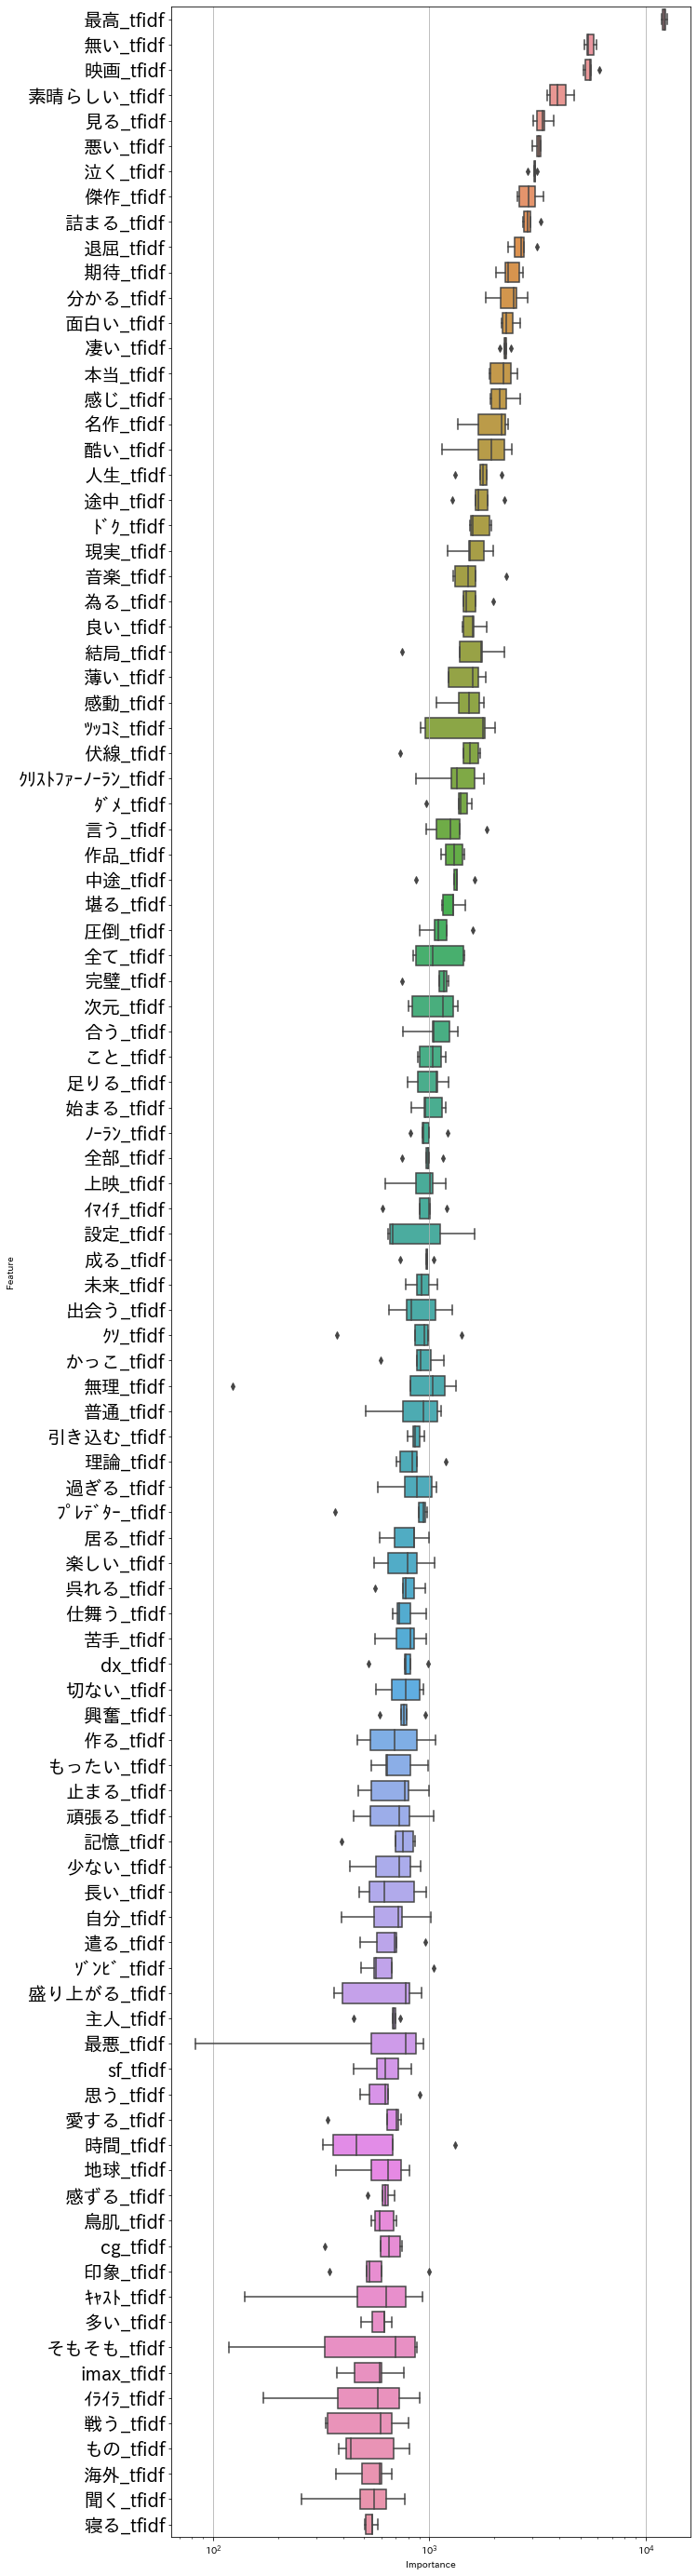

In [ ]:
# 平均値でソートする
sorted_indices = importance_df.mean(axis=0).sort_values(ascending=False).index
sorted_importance_df = importance_df.loc[:, sorted_indices]

# 上位をプロットする
PLOT_TOP_N = 100
plot_cols = sorted_importance_df.columns[:PLOT_TOP_N]
_, ax = plt.subplots(figsize=(10, 50))
ax.grid()
ax.set_xscale('log')
ax.set_ylabel('Feature')
plt.yticks(fontsize=20)
ax.set_xlabel('Importance')
sns.boxplot(data=sorted_importance_df[plot_cols],
                orient='h',
                ax=ax)
plt.show()

In [ ]:
pred = cvbooster.predict(valid_X)

In [ ]:
pred

[array([3.60668803, 3.79864508, 3.65213005, ..., 3.16822871, 3.62422948,
        3.60438344]),
 array([3.69670429, 3.70052439, 3.59775949, ..., 3.3204927 , 3.56632069,
        3.65479347]),
 array([3.6518955 , 3.67842231, 3.61943196, ..., 3.34103786, 3.5800998 ,
        3.81331024]),
 array([3.68159033, 3.73465169, 3.56342558, ..., 3.23796518, 3.54664429,
        3.64083702]),
 array([3.58087849, 3.60269333, 3.76696486, ..., 3.15992281, 3.58344808,
        3.59112594])]

In [ ]:
predict = np.stack(pred).mean(axis=0)

In [ ]:
predict

array([3.64355133, 3.70298736, 3.63994239, ..., 3.24552945, 3.58014847,
       3.66089002])

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(valid_y, predict))

In [ ]:
rmse

0.6447042742541078

In [ ]:
R2 = 1- ((rmse**2)*len(predict) / valid_y.var())

In [ ]:
R2

-4482.460242244846

Observed-Predicted(yyplot) <br>

評価指標ではないが，回帰分析の良し悪しを評価する方法の一つ．<br>
対角線上に散らばっているほど良い予測と言える．


In [ ]:
import matplotlib.pyplot as plt 
%matplotlib inline 
def yyplot(y_obs, y_pred):
  yvalues = np.concatenate([y_obs.flatten(), y_pred.flatten()])
  ymin, ymax, yrange = np.amin(yvalues), np.amax(yvalues), np.ptp(yvalues)
  fig = plt.figure(figsize=(10,10))
  plt.scatter(y_obs, y_pred)
  plt.plot([ymin - yrange*0.01, ymax + yrange*0.01],[ymin - yrange * 0.01, ymax + yrange * 0.01])
  plt.xlim(ymin - yrange * 0.01, ymax + yrange * 0.01)
  plt.ylim(ymin - yrange * 0.01, ymax + yrange * 0.01)
  plt.xlabel('y_obserbed', fontsize=24)
  plt.ylabel('y_predicted', fontsize=24)
  plt.title('yyplot', fontsize=24)
  plt.tick_params(labelsize=16)
  plt.show() 

  return fig

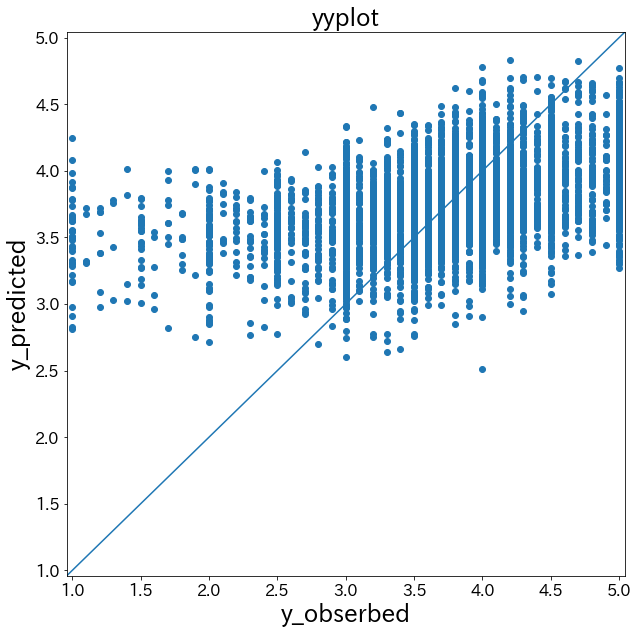

In [ ]:
fig = yyplot(valid_y.values, predict)

1～2.5までを大きく外してる

In [ ]:
result = pd.DataFrame(
    {'valid_y':valid_y.values,
     'predict':predict,
     'absolute_error': np.abs(valid_y.values - predict),
     }        )

result

,valid_y,predict,absolute_error
0,3.5,3.643551,0.143551
1,3.6,3.702987,0.102987
2,3.3,3.639942,0.339942
3,3.0,3.601179,0.601179
4,3.4,3.661216,0.261216
...,...,...,...
5642,3.6,3.750225,0.150225
5643,5.0,3.924260,1.075740
5644,2.5,3.245529,0.745529
5645,5.0,3.580148,1.419852


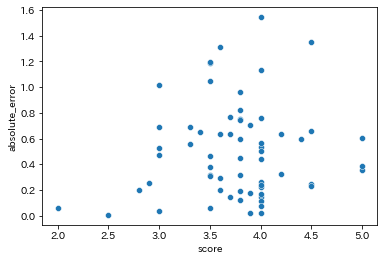

In [ ]:
sns.scatterplot(x=valid_y,y=result.absolute_error )